# **Project Overview**
This project analyzes the lyrics of Taylor Swift’s songs using natural language processing (NLP) and sentiment analysis. The dataset comes from [this open Kaggle source](https://www.kaggle.com/datasets/tksmax/taylorswiftlyrics/data), with an added column for the year of release. For songs that were re-released (like in her "Taylor’s Version" albums), the newer release year was used.

In [1]:
# Install Required Libraries
!pip install vaderSentiment bertopic[visualization] sentence-transformers transformers torch -q

In [2]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk import word_tokenize, pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
import spacy
import matplotlib.ticker as ticker
from bertopic import BERTopic
from transformers import pipeline, AutoTokenizer

# Download NLTK and spaCy resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Load Dataset and Clean Lyrics
df = pd.read_csv("final_lyrics_with_year.csv")

def clean_lyrics(text):
    text = re.sub(r'\[.*?\]', '', str(text))
    text = text.encode('utf-8', 'ignore').decode('utf-8')
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

df['CleanedLyrics'] = df['Lyrics'].apply(clean_lyrics)

In [4]:
# Basic Statistics
df['WordCount'] = df['CleanedLyrics'].apply(lambda x: len(x.split()))
all_words = ' '.join(df['CleanedLyrics']).split()

print("Number of Songs:", len(df))
print("Average Words per Song:", round(df['WordCount'].mean(), 2))
print("Total Words:", len(all_words))
print("Unique Words:", len(set(all_words)))


Number of Songs: 199
Average Words per Song: 361.75
Total Words: 71989
Unique Words: 4388


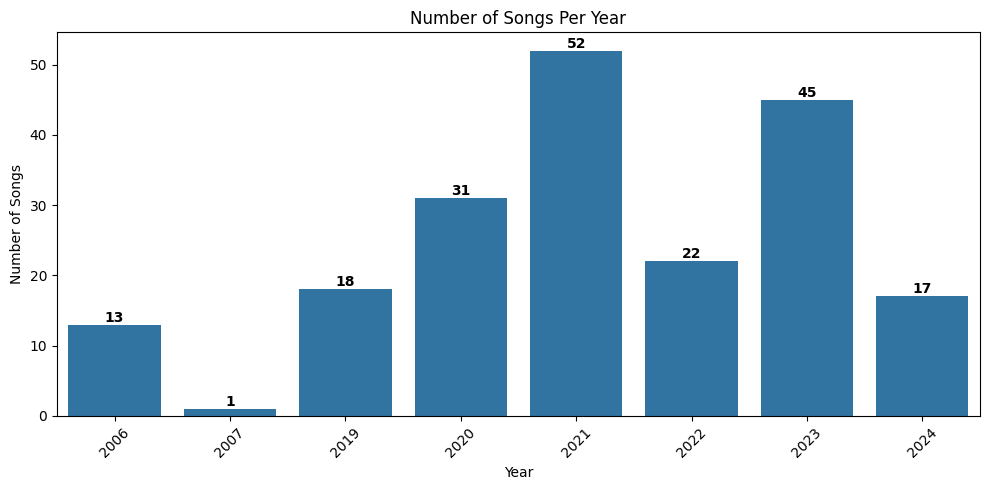

In [5]:
# Song Counts by Year
def plot_song_counts(data, title):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=data, x='Year', order=sorted(data['Year'].unique()))
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Number of Songs")
    plt.xticks(rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_song_counts(df, "Number of Songs Per Year")




Since there are only a few songs between 2006 and 2019, we will exclude them from the dataset to focus on more recent releases. This gives us 185 songs, which are around 68% of all her songs (by April 2025 she had around 274 songs).



Number of Songs: 185


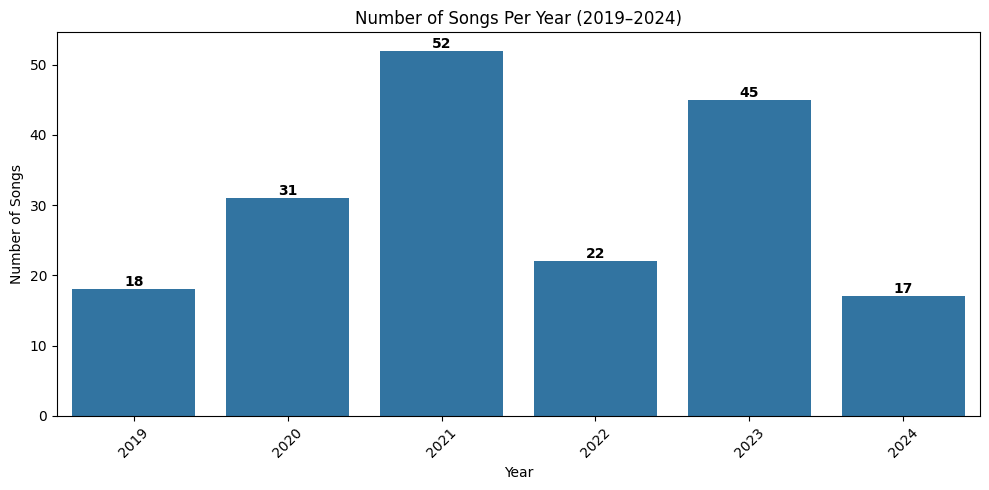

In [6]:
df = df[df['Year'] >= 2019]
print("Number of Songs:", len(df))
plot_song_counts(df, "Number of Songs Per Year (2019–2024)")

In [7]:
# Part-of-Speech Tagging and Frequency Counts
doc = nlp(' '.join(df['CleanedLyrics']))
pos_counts = {'verbs': Counter(), 'nouns': Counter(), 'adjectives': Counter(), 'adverbs': Counter()}
pos_mapping = {'VERB': 'verbs', 'NOUN': 'nouns', 'ADJ': 'adjectives', 'ADV': 'adverbs'}

for token in doc:
    if token.is_alpha and not token.is_stop:
        pos_key = pos_mapping.get(token.pos_)
        if pos_key:
            pos_counts[pos_key][token.lemma_] += 1

print("Top Verbs:", pos_counts['verbs'].most_common(10))
print("Top Nouns:", pos_counts['nouns'].most_common(10))
print("Top Adjectives:", pos_counts['adjectives'].most_common(10))
print("Top Adverbs:", pos_counts['adverbs'].most_common(10))

Top Verbs: [('know', 647), ('m', 426), ('s', 292), ('think', 260), ('go', 252), ('get', 249), ('come', 239), ('want', 216), ('say', 179), ('love', 165)]
Top Nouns: [('time', 335), ('love', 267), ('baby', 174), ('night', 154), ('d', 141), ('thing', 138), ('way', 137), ('eye', 107), ('man', 103), ('life', 94)]
Top Adjectives: [('good', 153), ('ill', 147), ('bad', 109), ('little', 74), ('well', 73), ('long', 57), ('red', 53), ('new', 50), ('mad', 45), ('right', 43)]
Top Adverbs: [('away', 110), ('right', 88), ('forever', 82), ('long', 47), ('home', 45), ('well', 40), ('maybe', 29), ('anymore', 26), ('someday', 26), ('soon', 24)]


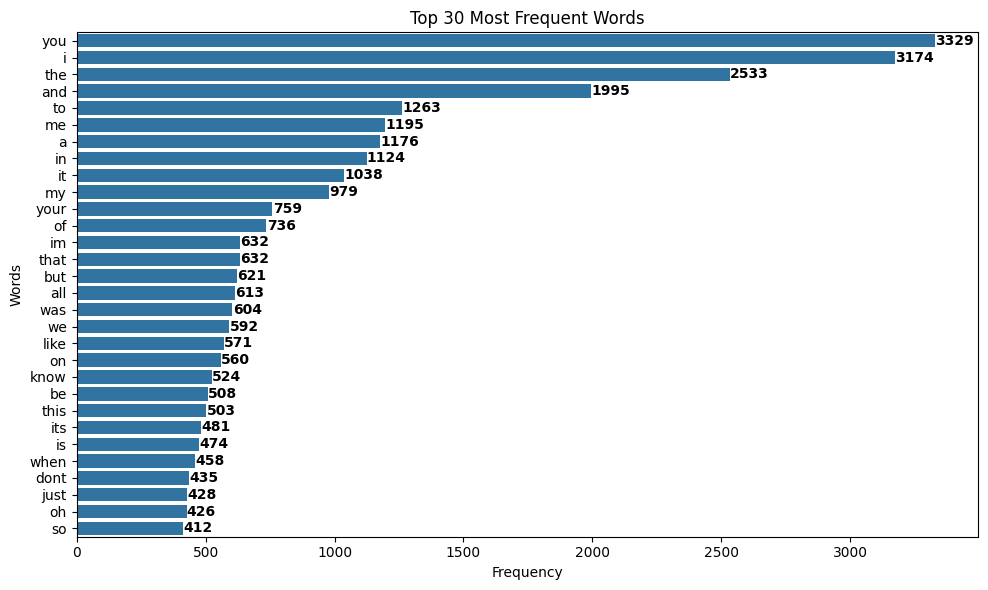

In [8]:
# Most Common Words
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=[c for _, c in common_words], y=[w for w, _ in common_words])
plt.title("Top 30 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
for i, (word, count) in enumerate(common_words):
    ax.text(count + 1, i, str(count), va='center', fontweight='bold')
plt.tight_layout()
plt.show()


We employ two popular sentiment analysis tools: **TextBlob** and **VADER**.

***TextBlob*** is a simple, rule-based tool that analyzes text and returns:

* Polarity: a score between -1 (very negative) and 1 (very positive).
* Subjectivity: a score between 0 (very objective) and 1 (very subjective).

This helps us understand not only whether a song sounds positive or negative, but also how personal or emotional the lyrics are.

***VADER*** (Valence Aware Dictionary for sEntiment Reasoning) is a pre-trained model designed specifically for analyzing sentiment in social media and short texts. It provides:

* A compound score ranging from -1 to 1 that captures the overall sentiment.

* A categorical label (Positive, Negative, or Neutral) based on that score.

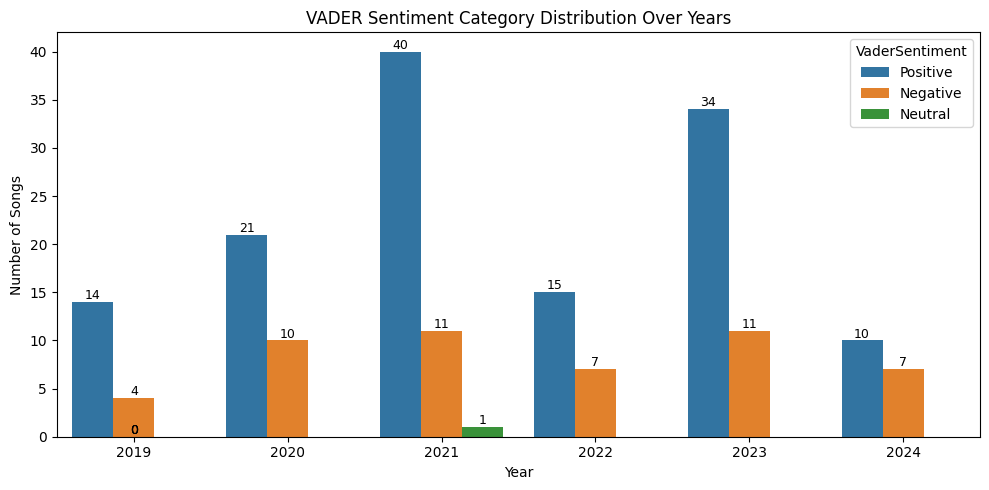

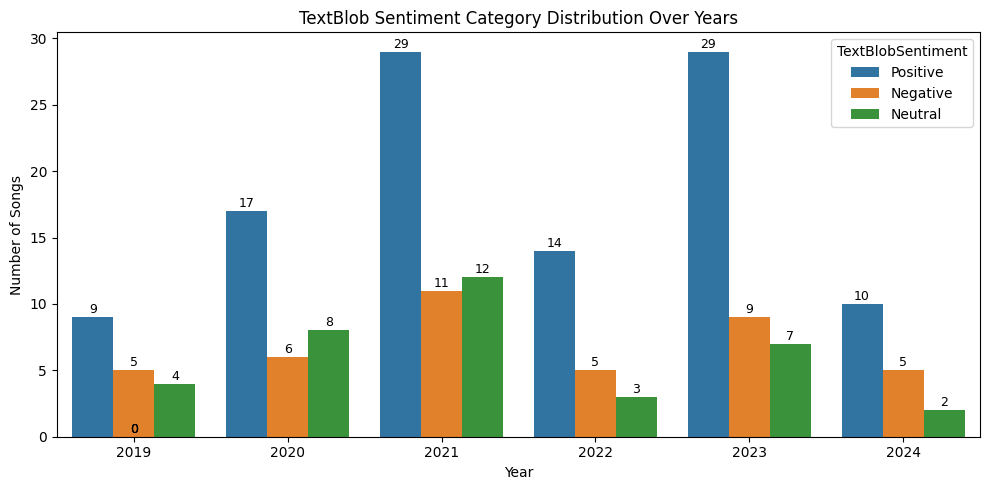

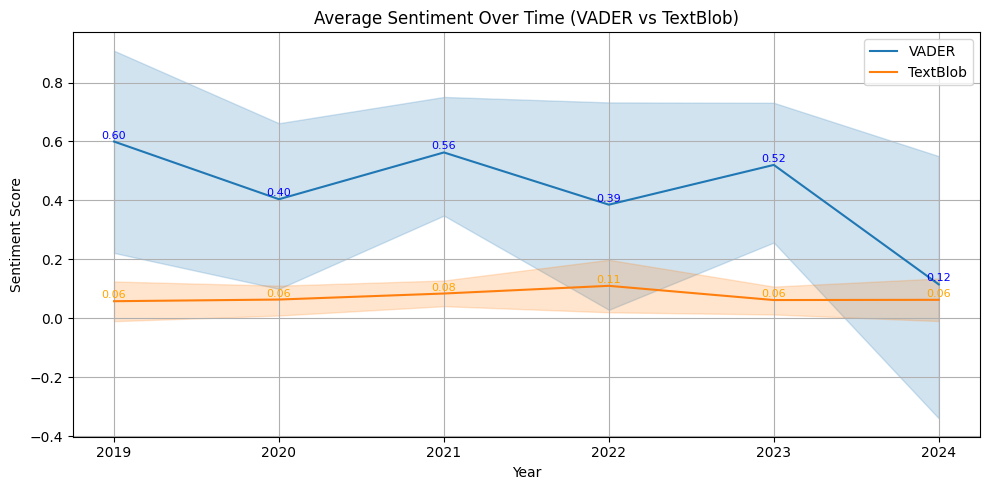

Most Positive (VADER): This Love (Taylor’s Version)
Most Negative (VADER): Shake It Off (Taylor's Version)
Most Positive (TextBlob): Bejeweled
Most Negative (TextBlob): Shake It Off (Taylor's Version)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from textblob import TextBlob

# Calculate TextBlob sentiment
df[['Polarity', 'Subjectivity']] = df['CleanedLyrics'].apply(
    lambda text: pd.Series([TextBlob(text).sentiment.polarity, TextBlob(text).sentiment.subjectivity])
)

# Classify TextBlob sentiment by polarity
def classify_textblob(p):
    if p >= 0.05:
        return 'Positive'
    elif p <= -0.05:
        return 'Negative'
    return 'Neutral'

df['TextBlobSentiment'] = df['Polarity'].apply(classify_textblob)


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Run VADER sentiment
vader = SentimentIntensityAnalyzer()
df['VaderCompound'] = df['CleanedLyrics'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Categorize sentiment
def classify_vader(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    return 'Neutral'

df['VaderSentiment'] = df['VaderCompound'].apply(classify_vader)

# -------------------------------
# VADER Sentiment Category Plot
# -------------------------------
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='Year', hue='VaderSentiment', order=sorted(df['Year'].unique()))
plt.title("VADER Sentiment Category Distribution Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Songs")

# Add value labels
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2, height + 0.3, str(height), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# -------------------------------
# TextBlob Sentiment Category Plot
# -------------------------------
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='Year', hue='TextBlobSentiment', order=sorted(df['Year'].unique()))
plt.title("TextBlob Sentiment Category Distribution Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Songs")

# Add value labels
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2, height + 0.3, str(height), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# -------------------------------
# Average Sentiment Over Time (Line Plot)
# -------------------------------
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=df, x='Year', y='VaderCompound', label='VADER')
sns.lineplot(data=df, x='Year', y='Polarity', label='TextBlob')

# Add value labels for both lines
for year in sorted(df['Year'].unique()):
    avg_vader = df[df['Year'] == year]['VaderCompound'].mean()
    avg_blob = df[df['Year'] == year]['Polarity'].mean()
    plt.text(year, avg_vader + 0.01, f"{avg_vader:.2f}", color='blue', fontsize=8, ha='center')
    plt.text(year, avg_blob + 0.01, f"{avg_blob:.2f}", color='orange', fontsize=8, ha='center')

plt.title("Average Sentiment Over Time (VADER vs TextBlob)")
plt.grid(True)
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# -------------------------------
# Most Positive/Negative Songs (VADER)
# -------------------------------
print("Most Positive (VADER):", df.loc[df['VaderCompound'].idxmax()]['Song'])
print("Most Negative (VADER):", df.loc[df['VaderCompound'].idxmin()]['Song'])

# -------------------------------
# Most Positive/Negative Songs (TextBlob)
# -------------------------------
print("Most Positive (TextBlob):", df.loc[df['Polarity'].idxmax()]['Song'])
print("Most Negative (TextBlob):", df.loc[df['Polarity'].idxmin()]['Song'])


* This Love (Taylor’s Version) https://youtu.be/mvxQYPR4lmU?si=IhtNsoC8BwoRq139
* Shake It Off (Taylor's Version) https://youtu.be/mvVBuG4IOW4?si=aPoQnchZHNCgBfAB
* Bejeweled https://youtu.be/b7QlX3yR2xs?si=iGYeIsiEhye6khhb

# Sentiment and Emotion Analysis with BERT and RoBERTa
In this part, we use transformer-based models from Hugging Face to analyze sentiment and emotion in Taylor Swift’s lyrics.

**BERT Sentiment:** We use a fine-tuned version of BERT (distilbert-base-uncased-finetuned-sst-2-english) to classify each song's sentiment as positive or negative, and to give a confidence score for the prediction.

**RoBERTa Emotion:** We also use a model fine-tuned for emotion detection (j-hartmann/emotion-english-distilroberta-base) to identify the dominant emotion in each song (e.g., joy, sadness, anger, etc.).

Because these models have a token limit (512 tokens), we use a custom truncation function to safely shorten longer lyrics without breaking the model input.

We then visualize:

* How BERT sentiment and VADER sentiment compare over time.

* The distribution of predicted BERT sentiments.

* The frequency of emotions detected by RoBERTa across all songs and over the years.

In [10]:
# BERT & RoBERTa Sentiment and Emotion
bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
bert_sentiment = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", tokenizer=bert_tokenizer)

emotion_tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None, tokenizer=emotion_tokenizer)

def safe_truncate(text, tokenizer, max_length=512):
    tokens = tokenizer.encode(text, truncation=True, max_length=max_length, return_tensors=None)
    return tokenizer.decode(tokens, skip_special_tokens=True)

def get_bert_sentiment(text):
    if not text:
        return pd.Series([None, None])
    try:
        truncated = safe_truncate(text, bert_tokenizer)
        result = bert_sentiment(truncated)[0]
        return pd.Series([result['label'], result['score']])
    except:
        return pd.Series([None, None])

df[['BERTSentiment', 'BERTScore']] = df['CleanedLyrics'].apply(get_bert_sentiment)

def get_emotion(text):
    if not text:
        return pd.Series([None, None])
    try:
        truncated = safe_truncate(text, emotion_tokenizer)
        results = emotion_model(truncated)
        top_emotion = max(results[0], key=lambda i: i['score'])
        return pd.Series([top_emotion['label'], top_emotion['score']])
    except:
        return pd.Series([None, None])

df[['Emotion', 'EmotionScore']] = df['CleanedLyrics'].apply(get_emotion)

Device set to use cpu
Device set to use cpu


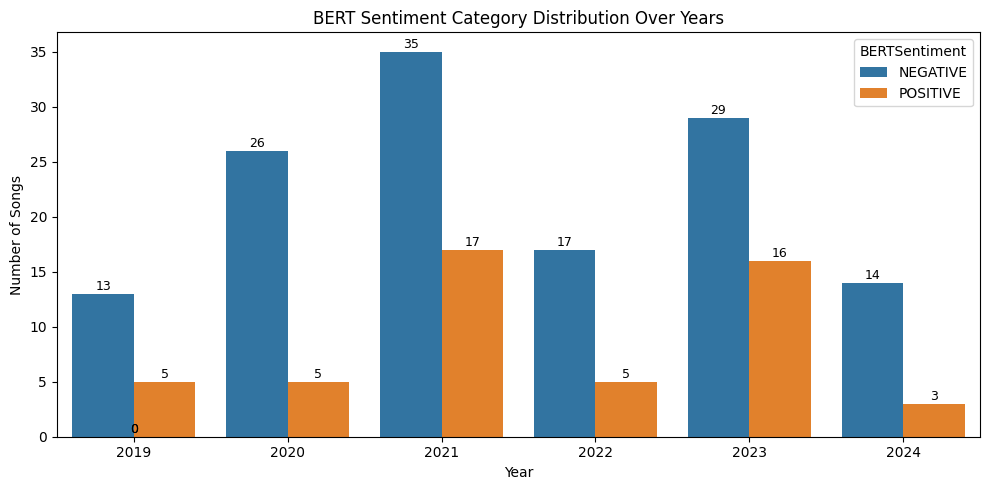

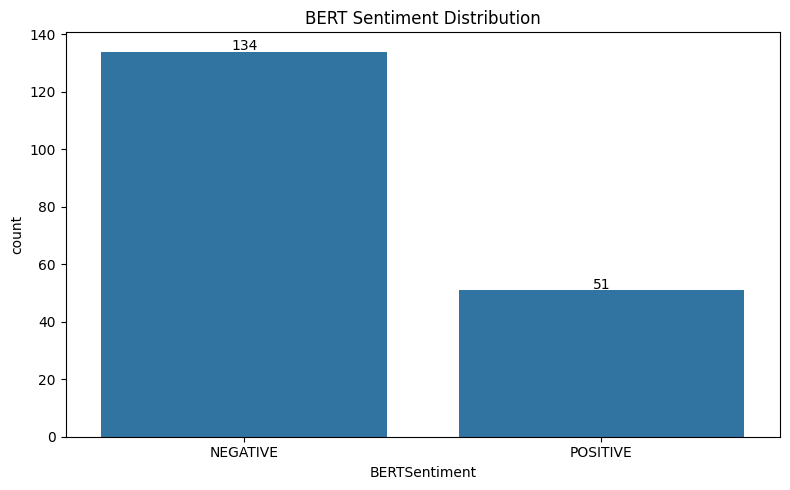

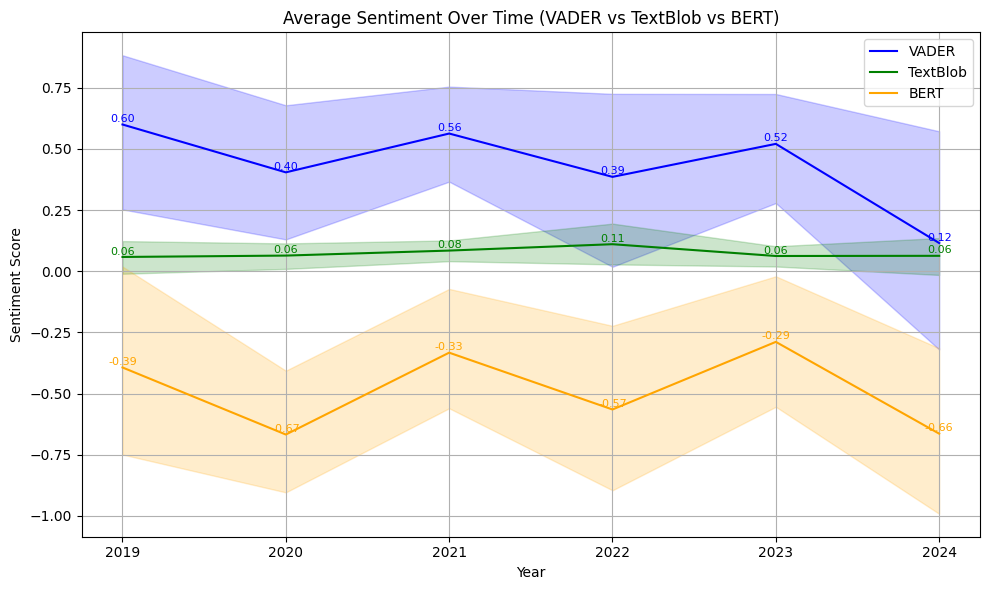

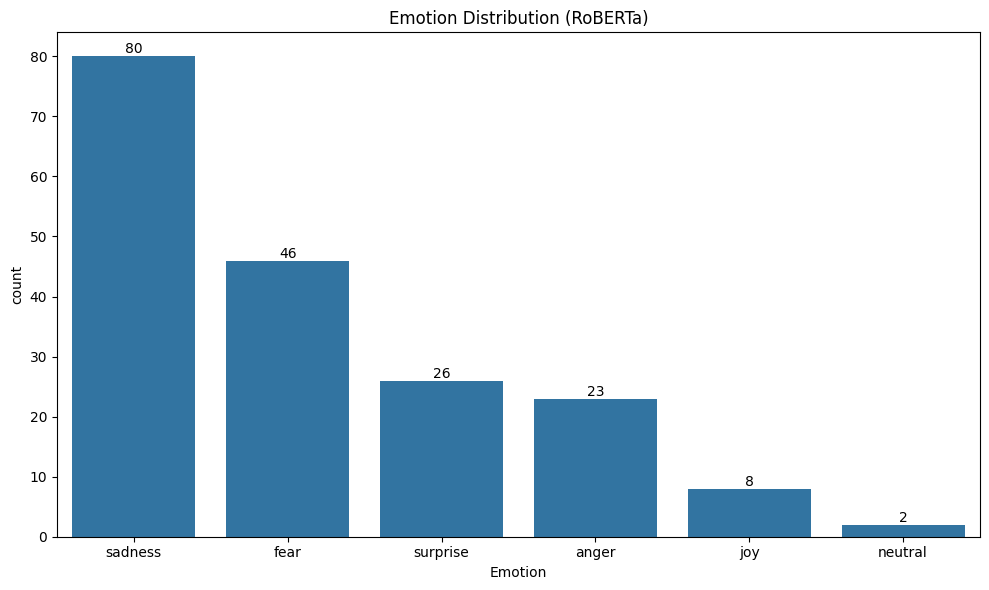

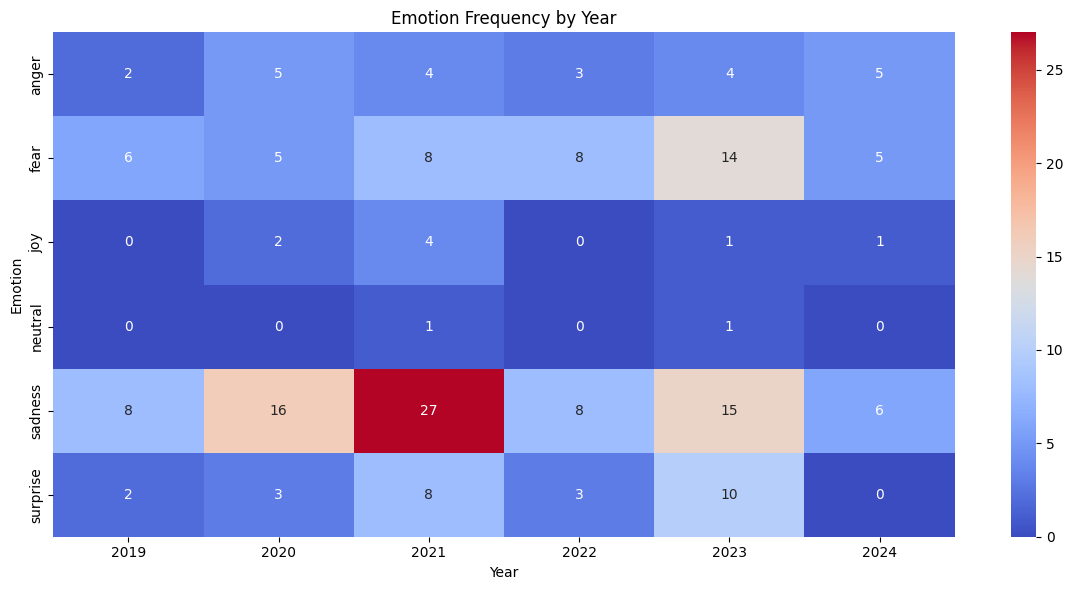

In [15]:
# Classify BERT sentiment
df['BERTSentiment'] = df['BERTSentiment'].fillna('Unknown')  # in case of missing

# -------------------------------
# BERT Sentiment Category Over Years
# -------------------------------
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='Year', hue='BERTSentiment', order=sorted(df['Year'].unique()))
plt.title("BERT Sentiment Category Distribution Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Songs")

# Add value labels
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2, height + 0.3, str(height), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# -------------------------------
# BERT Sentiment Distribution Overall
# -------------------------------
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='BERTSentiment', order=df['BERTSentiment'].value_counts().index)
plt.title("BERT Sentiment Distribution")

# Add value labels
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, str(height), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))


# Convert BERT sentiment to numeric polarity
def convert_bert_sentiment(row):
    if row['BERTSentiment'] == 'POSITIVE':
        return row['BERTScore']
    elif row['BERTSentiment'] == 'NEGATIVE':
        return -row['BERTScore']
    return 0  # or np.nan if you want to ignore 'Unknown'

df['BERTPolarity'] = df.apply(convert_bert_sentiment, axis=1)

# Plot each sentiment source
sns.lineplot(data=df, x='Year', y='VaderCompound', label='VADER', color='blue')
sns.lineplot(data=df, x='Year', y='Polarity', label='TextBlob', color='green')
sns.lineplot(data=df, x='Year', y='BERTPolarity', label='BERT', color='orange')

plt.title("Average Sentiment Over Time (VADER vs TextBlob vs BERT)")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Add value labels for each year and model
for year in sorted(df['Year'].unique()):
    year_df = df[df['Year'] == year]
    if not year_df.empty:
        avg_vader = year_df['VaderCompound'].mean()
        avg_blob = year_df['Polarity'].mean()
        avg_bert = year_df['BERTPolarity'].mean()

        # Label points
        plt.text(year, avg_vader + 0.01, f"{avg_vader:.2f}", fontsize=8, ha='center', color='blue')
        plt.text(year, avg_blob + 0.01, f"{avg_blob:.2f}", fontsize=8, ha='center', color='green')
        plt.text(year, avg_bert + 0.01, f"{avg_bert:.2f}", fontsize=8, ha='center', color='orange')

plt.legend()
plt.tight_layout()
plt.show()


# Emotion Distribution (RoBERTa) with labels
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Emotion', order=df['Emotion'].value_counts().index)
plt.title("Emotion Distribution (RoBERTa)")

# Add value labels
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, str(height), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Emotion by Year Heatmap (already has annot=True)
emotion_by_year = df.groupby(['Year', 'Emotion']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(emotion_by_year.T, annot=True, fmt="d", cmap='coolwarm')
plt.title("Emotion Frequency by Year")
plt.tight_layout()
plt.show()

In [12]:
# -------------------------------
# Most Positive/Negative Songs (BERT)
# -------------------------------
# Make sure BERTScore is numeric and clean
df['BERTScore'] = pd.to_numeric(df['BERTScore'], errors='coerce')
df_clean_bert = df.dropna(subset=['BERTScore'])

# Filter first
bert_positive = df_clean_bert[df_clean_bert['BERTSentiment'] == 'POSITIVE']
bert_negative = df_clean_bert[df_clean_bert['BERTSentiment'] == 'NEGATIVE']

# Apply idxmax within each filtered subset
most_positive_bert = bert_positive.loc[bert_positive['BERTScore'].idxmax()]
most_negative_bert = bert_negative.loc[bert_negative['BERTScore'].idxmax()]

print("Most Positive Song (BERT):", most_positive_bert['Song'], "| Score:", round(most_positive_bert['BERTScore'], 3))
print("Most Negative Song (BERT):", most_negative_bert['Song'], "| Score:", round(most_negative_bert['BERTScore'], 3))


Most Positive Song (BERT): The Best Day (Taylor’s Version) | Score: 0.999
Most Negative Song (BERT): illicit affairs | Score: 1.0


* The Best Day: https://youtu.be/KZeI9I875Ig?si=mPu0nWmMCuRyxuLu
* illicit affairs https://youtu.be/MLV2SJKWk4M?si=IeO9J26xpqFgWnyu

In [13]:
import pandas as pd

# Ensure sentiment scores are numeric
df['Polarity'] = pd.to_numeric(df['Polarity'], errors='coerce')
df['VaderCompound'] = pd.to_numeric(df['VaderCompound'], errors='coerce')
df['BERTScore'] = pd.to_numeric(df['BERTScore'], errors='coerce')

# Drop rows missing any of the scores
df_clean = df.dropna(subset=['Polarity', 'VaderCompound', 'BERTScore'])

# Helper to get top N songs based on sentiment
def get_top_songs(df, score_col, label_col=None, label_val=None, top_n=5, ascending=True):
    if label_col and label_val:
        df = df[df[label_col] == label_val]
    return df.sort_values(by=score_col, ascending=ascending).head(top_n)[['Song', score_col]]

# Top 5 positive and negative from each model
textblob_pos = get_top_songs(df_clean, 'Polarity', ascending=False)
textblob_neg = get_top_songs(df_clean, 'Polarity', ascending=True)

vader_pos = get_top_songs(df_clean, 'VaderCompound', ascending=False)
vader_neg = get_top_songs(df_clean, 'VaderCompound', ascending=True)

bert_pos = get_top_songs(df_clean, 'BERTScore', 'BERTSentiment', 'POSITIVE', ascending=False)
bert_neg = get_top_songs(df_clean, 'BERTScore', 'BERTSentiment', 'NEGATIVE', ascending=False)

# Combine into a single DataFrame
comparison_table = pd.DataFrame({
    'TextBlob_Positive': textblob_pos['Song'].values,
    'TextBlob_Score': textblob_pos['Polarity'].round(2).values,
    'TextBlob_Negative': textblob_neg['Song'].values,
    'TextBlob_Score_Neg': textblob_neg['Polarity'].round(2).values,

    'VADER_Positive': vader_pos['Song'].values,
    'VADER_Score': vader_pos['VaderCompound'].round(2).values,
    'VADER_Negative': vader_neg['Song'].values,
    'VADER_Score_Neg': vader_neg['VaderCompound'].round(2).values,

    'BERT_Positive': bert_pos['Song'].values,
    'BERT_Score': bert_pos['BERTScore'].round(2).values,
    'BERT_Negative': bert_neg['Song'].values,
    'BERT_Score_Neg': bert_neg['BERTScore'].round(2).values,
})

# Display the comparison
from IPython.display import display
display(comparison_table)


,TextBlob_Positive,TextBlob_Score,TextBlob_Negative,TextBlob_Score_Neg,VADER_Positive,VADER_Score,VADER_Negative,VADER_Score_Neg,BERT_Positive,BERT_Score,BERT_Negative,BERT_Score_Neg
0,Bejeweled,0.49,Shake It Off (Taylor's Version),-0.44,This Love (Taylor’s Version),1.0,Shake It Off (Taylor's Version),-1.0,The Best Day (Taylor’s Version),1.0,illicit affairs,1.0
1,We Were Happy (Taylor’s Version) (From The Vault),0.48,Maroon,-0.37,I Wish You Would (Taylor's Version),1.0,I Knew You Were Trouble (Taylor's Version),-1.0,Lover,1.0,‘tis the damn season,1.0
2,"You're On Your Own, Kid",0.41,mad woman,-0.30,London Boy,1.0,Down Bad,-1.0,We Were Happy (Taylor’s Version) (From The Vault),1.0,Down Bad,1.0
3,Welcome To New York (Taylor's Version),0.41,Down Bad,-0.25,Out Of The Woods (Taylor's Version),1.0,mad woman,-1.0,Fearless (Taylor’s Version),1.0,this is me trying,1.0
4,Midnight Rain,0.39,Bad Blood (Taylor's Version),-0.25,Better Man (Taylor's Version) (From The Vault),1.0,Bad Blood (Taylor's Version),-1.0,State Of Grace (Taylor's Version),1.0,willow,1.0
